#Data Loading : BERT MODEL


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import datasets
import torch
from datasets import Dataset
from transformers import BertTokenizerFast
import pandas as pd
batch_size=4  # change to 16 for full training
encoder_max_length=512
decoder_max_length=128
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

# Load CSV file into a Pandas DataFrame
df = pd.read_csv('test.csv')
train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing
# Calculate the lengths of each subset
num_samples = len(df)
num_train = int(num_samples * train_ratio)
num_val = int(num_samples * val_ratio)
num_test = num_samples - num_train - num_val
# Split the shuffled DataFrame into train, validation, and test sets
train_df = df.iloc[:num_train]
val_df = df.iloc[num_train:num_train + num_val]
test_df = df.iloc[num_train + num_val:]
# Convert Pandas DataFrame to datasets.Dataset
   # Use the first 100 rows for training

batch_size = 4  # Set batch size
train_data = Dataset.from_pandas(train_df[:700])
def process_data_to_model_inputs(batch):
    # Tokenize the inputs and labels
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=encoder_max_length)
    outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=decoder_max_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["decoder_input_ids"] = outputs.input_ids
    batch["decoder_attention_mask"] = outputs.attention_mask
    batch["labels"] = outputs.input_ids.copy()

    # Adjust labels to handle padding tokens
    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

    return batch

# Apply data processing function to the dataset
train_data = train_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)

# Set format for PyTorch tensors
train_data.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"]
)

# Split dataset into training and validation sets

val_data = Dataset.from_pandas(val_df[:70])  # Use rows 101-116 for validation

# Apply data processing function to the validation dataset
val_data = val_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)

# Set format for PyTorch tensors
val_data.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"]
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
from transformers import EncoderDecoderModel

bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [ ]:
#special tokens
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

#Beam Search
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
bert2bert.config.max_length = 250
bert2bert.config.min_length = 56
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

## Evaluation Metric: Rouge Score


In [ ]:
#Rouge Score
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid

    return {
        "rouge1_precision": round(rouge_output.precision, 4),
        "rouge1_recall": round(rouge_output.recall, 4),
        "rouge1_fmeasure": round(rouge_output.fmeasure, 4),
    }

<ipython-input-6-7e7e90dbf074>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")
/content/drive/MyDrive/colab_env/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


##Data Training


In [ ]:
# set training arguments - these params are not really tuned, feel free to change

training_args = Seq2SeqTrainingArguments(
    output_dir="./",  # Change output directory to a specific folder
    evaluation_strategy="steps",  # Evaluate every 'eval_steps' steps during training
    per_device_train_batch_size=8,  # Decrease batch size for better generalization
    per_device_eval_batch_size=8,  # Use the same batch size for evaluation
    predict_with_generate=True,  # Use generation during prediction
    logging_steps=50,  # Log training metrics every 50 steps
    save_steps=100,  # Save model checkpoints every 500 steps
    eval_steps=100,  # Evaluate the model every 200 steps
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    max_steps=500,  # Maximum number of training steps
    overwrite_output_dir=True,  # Overwrite the output directory if it exists
    save_total_limit=3,  # Limit the number of saved checkpoints
    fp16=True  # Enable mixed precision training (if supported by your hardware)
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bert2bert,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Rouge1 Precision,Rouge1 Recall,Rouge1 Fmeasure
100,0.826400,0.050853,0.028700,0.027800,0.018200
200,0.023200,0.000935,0.003700,0.006500,0.003700
300,0.002800,0.000466,0.015000,0.063000,0.023700
400,0.008900,0.000701,0.015100,0.063900,0.023600
500,0.006100,0.000323,0.000500,0.002900,0.000800


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 250, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decode

TrainOutput(global_step=500, training_loss=0.562930871039629, metrics={'train_runtime': 541.7541, 'train_samples_per_second': 7.383, 'train_steps_per_second': 0.923, 'total_flos': 2441547319910400.0, 'train_loss': 0.562930871039629, 'epoch': 5.681818181818182})

##Data Testing


In [ ]:
import datasets
from transformers import BertTokenizer, EncoderDecoderModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = bert2bert
model.to("cuda")


# only use 16 training examples for notebook - DELETE LINE FOR FULL TRAINING
test_data = Dataset.from_pandas(test_df[50:120])

batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["article"])

pred_str = results["pred"]
label_str = results["highlights"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)

Parameter 'function'=<function generate_summary at 0x78892df6ad40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [ ]:
results[1]

{'id': '9fe1164044881fb4b9d3d5eb22d09ebed5724e09',
 'highlights': 'The Mexican painter penned the letters to fellow artist Jose Bartoli from\xa01946 and 1949 while she was married to muralist\xa0Diego Rivera .\nThe 25 letters Jose had saved until his death in 1995 are headed to auction at Doyle New York on April 15 and expected sell upwards of $120,000 .',
 'pred': 'one one one 1 1 1111222 2 2 22211 1 1 i i i me me me you you you your your your his his his your your my my my your your their their their our our our their their your your our our your your her her her she she she her her your your its its her her its its its their their its its his his their their his his its its the the the its its whose whose whose which which which whom whom whom whose whose who who who whom whom who who whose whose whom whom when when when whenever whenever whenever wherever wherever wherever whenever whenever anytime anytime anytime whenever whenever every every every each each each every every all a

#T-5 Model

##Data Loading

In [1]:
import pandas as pd
df = pd.read_csv('test.csv')
max_length=512
target_length=128
articles=df["article"].tolist()
highlights=df["highlights"].tolist()
df = pd.DataFrame({
    "source_text": ['summarize: ' + article for article in articles],
    "target_text": highlights
})
df.head()

,source_text,target_text
0,summarize: Ever noticed how plane seats appear...,Experts question if packed out planes are put...
1,summarize: A drunk teenage boy had to be rescu...,Drunk teenage boy climbed into lion enclosure ...
2,summarize: Dougie Freedman is on the verge of ...,Nottingham Forest are close to extending Dougi...
3,summarize: Liverpool target Neto is also wante...,Fiorentina goalkeeper Neto has been linked wit...
4,summarize: Bruce Jenner will break his silence...,"Tell-all interview with the reality TV star, 6..."


##Data Training


In [2]:
import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config


from simplet5 import SimpleT5
model = SimpleT5()
model.from_pretrained(model_type="t5", model_name='t5-base')
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.utils.checkpoint
# Training parameters
MAX_EPOCHS = 12
TRAINING_SIZE = 200
max_length = 512  # Set your desired source sequence length
target_length = 128 # Set your desired target sequence length
train_df = df.iloc[0:int(0.7 * TRAINING_SIZE)]
eval_df = df.iloc[int(0.7 * TRAINING_SIZE):TRAINING_SIZE]
# Split dataset into train and eval
if len(train_df) == 0 or len(eval_df) == 0:
    raise ValueError("Training or evaluation dataset is empty. Please check your dataset.")

# Train the model
try:
    model.train(train_df=train_df,
                eval_df=eval_df,
                source_max_token_len=max_length,
                target_max_token_len=target_length,
                batch_size=4,
                max_epochs=MAX_EPOCHS,
                use_gpu=True)
except Exception as e:
    print(f"Error during training: {e}")

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve per

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

##Rouge Score: Evaluation Metric

In [3]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24951 sha256=16d61c4b8e7f27cb05807737685e59322be289c8f66bc0159103466145d54aac
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [28]:
from rouge_score import rouge_scorer

def compute_rouge_scores(hypotheses, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(hypotheses, references)
    return rouge_scores['rouge1']


In [40]:
import os
model_path = ''
rootdir = 'outputs/'
for it in os.scandir(rootdir):
    if it.is_dir():
        if 'simplet5-epoch-'+(str)(MAX_EPOCHS-1) in it.path:
            model_path = it.path
            print(model_path)

model.load_model("t5","./"+model_path, use_gpu=True)



outputs/simplet5-epoch-11-train-loss-0.2469-val-loss-2.1918


##Data Testing

In [41]:
df= pd.read_csv('test.csv')
test_df=df[TRAINING_SIZE:TRAINING_SIZE+40].reset_index(drop=True)
actual_summary=test_df['highlights'].tolist()
article=test_df['article'].tolist()


In [42]:
actual_summaries = []
predicted_summaries = []
rouge_scores = []
precision_values = []
recall_values = []
fmeasure_values = []
for i in range(len(actual_summary)):
  predicted_summary = model.predict(
            source_text=article[i],
            max_length=128,  # Set your desired maximum summary length
            num_return_sequences=1,
            num_beams=14, #increase beam size from 4 to 14
            top_k=50,
            top_p=0.95,
            do_sample=False, #switched to false, for more deterministic
            repetition_penalty=1.1,
            length_penalty=1.0,
            early_stopping=True,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )
  rouge_score = compute_rouge_scores(predicted_summary[0], actual_summary[i])
  actual_summaries.append(actual_summary[i])
  predicted_summaries.append(predicted_summary[0])
  fmeasure_values.append(rouge_score.fmeasure)
  precision_values.append(rouge_score.precision)
  recall_values.append(rouge_score.recall)

Token indices sequence length is longer than the specified maximum sequence length for this model (1937 > 512). Running this sequence through the model will result in indexing errors


In [43]:
tested_df = pd.DataFrame({
    'actual_summary': actual_summaries,
    'predicted_summary': predicted_summaries,
    'rouge_score_precision': precision_values,
    'rouge_score_recall': recall_values,
    'rouge_score_fmeasure': fmeasure_values
})

In [44]:
tested_df

,actual_summary,predicted_summary,rouge_score_precision,rouge_score_recall,rouge_score_fmeasure
0,"Cows are treated as sacred in Nepal, where the...",Nepal received packets of 'beef masala' from P...,0.176471,0.191489,0.183673
1,Vice correspondent Gianna Toboni traveled to I...,Gianna Toboni traveled to India to explore the...,0.537037,0.386667,0.449612
2,New Royal Caribbean cruise ship Anthem of the ...,Anthem Of The Seas is Royal Caribbean's second...,0.288462,0.405405,0.337079
3,London Mayor warns the SNP want to 'end Britai...,Tory London Mayor Boris Johnson warns against ...,0.500000,0.280000,0.358974
4,The Large Hadron Collider (LHC) begins again a...,The Large Hadron Collider (LHC) is back in act...,0.722222,0.164557,0.268041
5,"Experience Berlin for £14, South Africa for £2...",a fraction of the price of a traditional 'holi...,0.555556,0.289855,0.380952
6,The spectacular photos were taken at paddy fie...,Photos taken by professional photographer Scot...,0.529412,0.490909,0.509434
7,They will be included in 2018 flight of Orion ...,Space Launch System (SLS) will launch the Orio...,0.775510,0.469136,0.584615
8,Lorna McCarthy was fatally stabbed through the...,Barry McCarthy fatally stabbed his ex-wife Lor...,0.586957,0.375000,0.457627
9,David Healy is head of psychiatry at the Herge...,Professor David Healy argues that the belief t...,0.452830,0.375000,0.410256


In [45]:
#For creating graphs
article = []
for i in range(len(precision_values)):
  article.append(i)


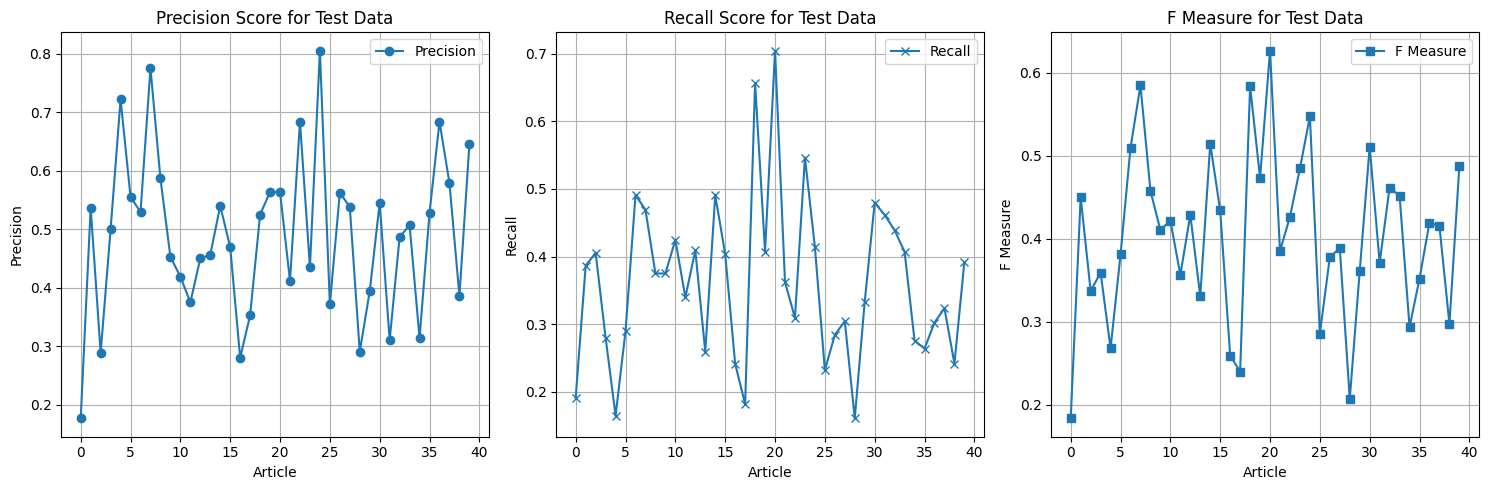

In [46]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Adjust figsize as needed


# Precision
axes[0].plot(article, precision_values, label='Precision', marker='o')
axes[0].set_xlabel('Article')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision Score for Test Data')
axes[0].legend()
axes[0].grid(True)

# Dataset 2
axes[1].plot(article, recall_values, label='Recall', marker='x')
axes[1].set_xlabel('Article')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall Score for Test Data')
axes[1].legend()
axes[1].grid(True)

# Dataset 3
axes[2].plot(article, fmeasure_values, label='F Measure', marker='s')
axes[2].set_xlabel('Article')
axes[2].set_ylabel('F Measure')
axes[2].set_title('F Measure for Test Data')
axes[2].legend()
axes[2].grid(True)

# Adjust layout and display the plots
plt.tight_layout()  # Automatically adjust subplot parameters to fit into the figure area
plt.show()


In [47]:
#Average Scores
import numpy as np
print("Average Precision:", np.mean(precision_values))
print("Average Recall:", np.mean(recall_values))
print("Average F Measure:", np.mean(fmeasure_values))

Average Precision: 0.48996629492862026
Average Recall: 0.36201666300039126
Average F Measure: 0.40328414708246685
